<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/GW_data_in_a_toy_universe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [ ]:
!pip install lalsuite

In [ ]:
!pip install latex

In [4]:
import lalsimulation as lalsim
import numpy as np
from scipy import stats
import pylab as plt
import lal
import pandas as pd
from scipy.special import logsumexp

In [5]:
data_frequency = 150 # In our universe, GW detectors only record data at 150Hz :)

def GW_detector_noise(N):


  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(data_frequency) / (4*deltaF)

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))

  return noise_re + 1j*noise_imag

In [6]:
def draw_mtotal(N):

  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.rvs(a, b, loc=mtot_mean, scale=np.sqrt(mtot_var),size=int(N))

In [7]:
# this is all bookkeepy stuff to allow us to evaluate a GW signal at GW frequency of 150Hz #####
f = np.array([data_frequency])
F = f#np.loadtxt("Freqs_long.txt")
F = lal.CreateREAL8Vector(len(F))
F.data[:] =  f
###############################################################################
def GW_signal(Mtotal):

  mass_ratio = 1 #all binaries in our universe contain equal-mass black holes
  Dist = 1e6*lal.lal.PC_SI #all binary black holes are located 0.1Gpc from our detector
  spin1x, spin1y, spin1z = 0, 0, 0 #black holes do not spin in our Universe
  spin2x, spin2y, spin2z = 0, 0, 0 #black holes do not spin in our Universe
  iota = 0 #all BBH obits are inclined such that their orbital plane is "face on"

  m1, m2 = Mtotal/(1+mass_ratio), Mtotal/(1+mass_ratio)

  m1 *= lal.lal.MSUN_SI #component mass into SI units
  m2 *= lal.lal.MSUN_SI
  WFdict = lal.CreateDict() #bookkeepy thing
  h = lalsim.SimIMRPhenomXPHMFrequencySequence(F, m1, m2, spin1x, \
            spin1y, spin1z, spin2x, spin2y, spin2z, Dist, iota, 0, 150, WFdict)
  
  signal = h[0].data.data + h[1].data.data #equal parts plus and cross polarization
  return signal

In [8]:
noise_measurements = GW_detector_noise(5e6)

In [9]:
BBH_masses = draw_mtotal(5e6)

In [10]:
signals = np.array([GW_signal(_m)[0] for _m in BBH_masses])

In [11]:
strain_data = signals + noise_measurements

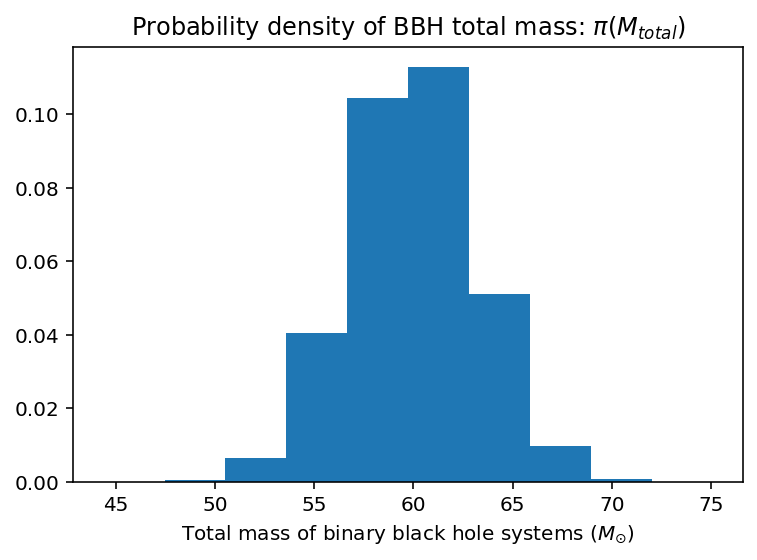

In [12]:
plt.hist(BBH_masses, density=True)
plt.xlabel(r"Total mass of binary black hole systems $(M_{\odot})$")
plt.title(r"Probability density of BBH total mass: $\pi(M_{total})$")
plt.show()

In [13]:
## bundle up our data, noise, masses into a pandas data frame 
_df = {'total mass':BBH_masses, 'strain_data':strain_data, 'noise':noise_measurements}
dataframe = pd.DataFrame(data=_df)

In [14]:
dataframe

,total mass,strain_data,noise
0,61.501551,-4.466780e-21+2.782726e-23j,7.055627e-24+4.689038e-24j
1,61.349297,-4.466470e-21+1.793634e-23j,-6.936680e-24-5.034796e-24j
2,64.327348,-4.750646e-21+2.808784e-23j,-4.280312e-24+1.595779e-24j
3,60.443511,-4.359818e-21+1.634503e-23j,1.541214e-23-5.655802e-24j
4,62.616503,-4.586126e-21+2.039844e-23j,-6.373418e-24-4.002199e-24j
...,...,...,...
4999995,59.128038,-4.254640e-21+1.834202e-23j,5.226551e-25-2.313525e-24j
4999996,60.695369,-4.393326e-21+2.638034e-23j,5.210798e-24+4.113605e-24j
4999997,60.577512,-4.380605e-21+1.988578e-23j,7.012561e-24-2.256163e-24j
4999998,62.303136,-4.544238e-21+8.836852e-24j,5.535561e-24-1.520172e-23j


In [15]:
strain_data_new = GW_detector_noise(1) + GW_signal(55)

In [16]:
precision = 24 #number of decimal places to round data

idx = np.where(np.around(strain_data,precision)==np.around(strain_data_new, precision))

In [17]:
# the part of the dataframe where the strain data equals the new data (to our set precision)
measurement_table = dataframe[dataframe.index.isin(idx[0])]

In [18]:
# this contains the total masses that produce strain data equal to what we just "measured"
# with this, we can estimate the probability of a the total mass given our newly measured data by counting  
measurement_table

,total mass,strain_data,noise
22141,55.179526,-3.900283e-21+1.801951e-23j,1.049585e-23+1.071694e-24j
59351,55.105138,-3.899850e-21+1.807714e-23j,4.659905e-24+1.195634e-24j
118277,55.001928,-3.899571e-21+1.751354e-23j,-3.745386e-24+7.238486e-25j
196405,55.057335,-3.899612e-21+1.825655e-23j,8.739097e-25+1.417592e-24j
209312,54.996073,-3.899651e-21+1.776192e-23j,-4.317708e-24+9.774360e-25j
...,...,...,...
4828110,55.016856,-3.900212e-21+1.846003e-23j,-3.131884e-24+1.657072e-24j
4843495,55.004394,-3.899606e-21+1.759901e-23j,-3.573368e-24+8.071333e-25j
4872174,54.906765,-3.899562e-21+1.767368e-23j,-1.173127e-23+9.684874e-25j
4943689,55.069237,-3.900284e-21+1.780192e-23j,1.203506e-24+9.523744e-25j


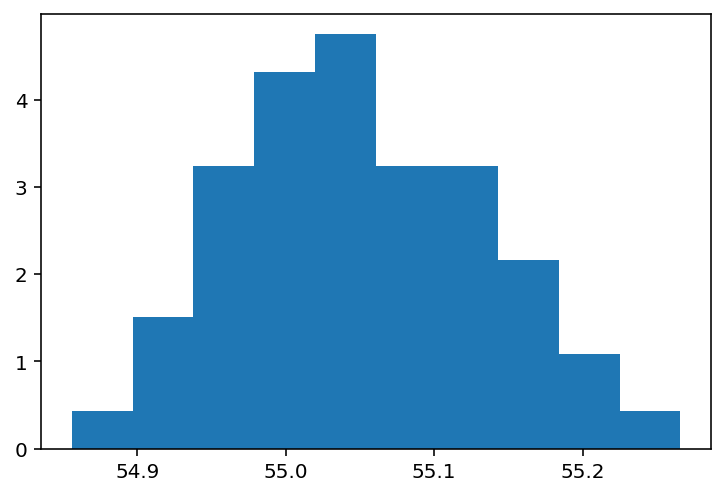

In [19]:
plt.hist(measurement_table['total mass'],density=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


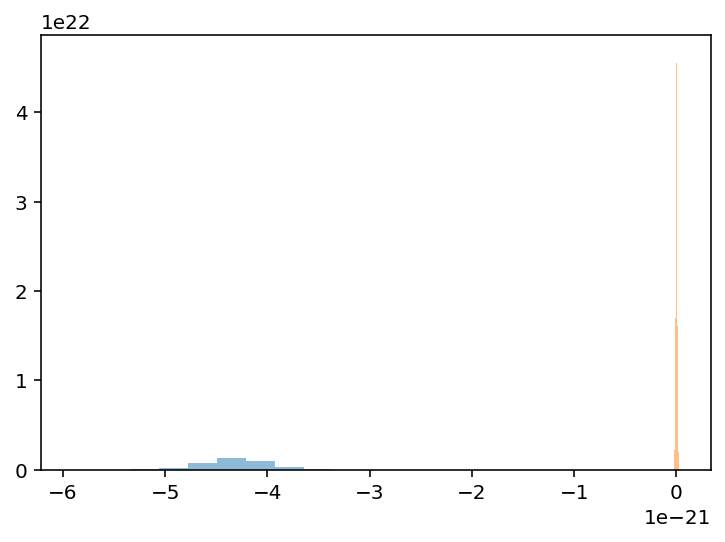

In [20]:
plt.hist(strain_data,density=True,alpha=0.5)
plt.hist(noise_measurements,density=True,alpha=0.5)
plt.show()

In [21]:
def lnL(data,mtotal):
  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(150) / (4*deltaF)

  signal = GW_signal(mtotal)[0]
  return stats.norm.logpdf(data, loc=signal, scale=np.sqrt(noise_var))

def lnpi(mtotal):
  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.logpdf(mtotal,a, b, loc=mtot_mean, scale=np.sqrt(mtot_var))


In [22]:
def ln_p_mtotal_given_data(mtotal, data):

  return lnpi(mtotal) + lnL(data, mtotal)

In [25]:
m_tot_list = np.linspace(54.4,55.5,10000)
ln_posterior = np.array([ln_p_mtotal_given_data(_m,strain_data_new) for _m in m_tot_list])
ln_evidence = logsumexp(ln_posterior,b=(m_tot_list[1]-m_tot_list[0]))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


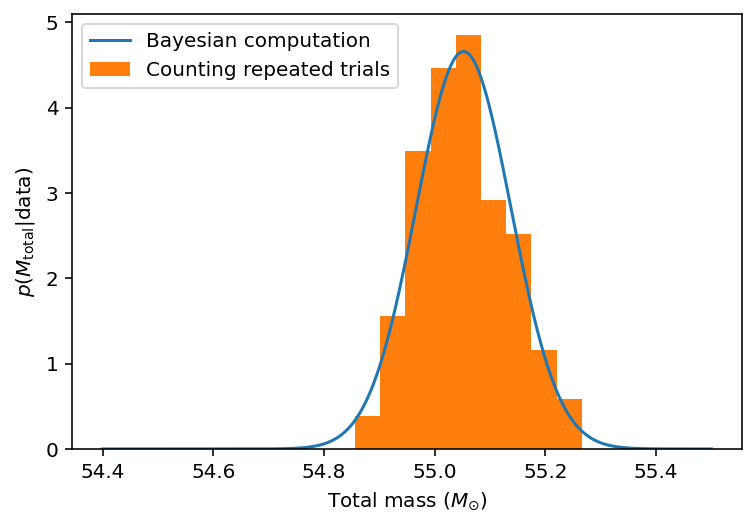

In [27]:
plt.plot(m_tot_list, np.exp(ln_posterior)/np.exp(ln_evidence),label='Bayesian computation')
plt.hist(measurement_table['total mass'],bins='auto',density=True,label='Counting repeated trials')
plt.legend(loc=2)
plt.xlabel("Total mass ($M_{\odot})$")
plt.ylabel("$p(M_{\mathrm{total}}|$data)")
plt.ylim(0)
plt.show()